### Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

In [ ]:
import tensorflow_hub as hub

### Set all the Constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_root='/content/drive/My Drive/images'
TRAINING_DATA_DIR = str(data_root)

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAINING_DATA_DIR,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1832 files belonging to 9 classes.


We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [ ]:
class_names = dataset.class_names
class_names

['Bhimsen_Temple',
 'Char_Narayan_Temple',
 'Dhungey_Dhara',
 'Garuda_Pillar',
 'Harishankara_temple',
 'Krishna_Mandir',
 'Narayan_Temple',
 'Octagonal_Chyasing_Deval',
 'Vishwanath_Temple']

In [ ]:
n_classes=len(class_names)
n_classes

9

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    print(image_batch[0])

(32, 128, 128, 3)
[6 4 2 4 4 7 4 0 2 8 8 1 4 8 0 6 6 8 1 6 4 2 7 4 5 5 5 0 0 8 6 7]
tf.Tensor(
[[[143.21094  170.21094  197.21094 ]
  [144.375    171.375    198.375   ]
  [146.69531  173.69531  200.69531 ]
  ...
  [ 26.789062  28.789062  27.789062]
  [ 30.820312  32.507812  32.445312]
  [ 43.992188  44.695312  42.34375 ]]

 [[143.23438  170.23438  197.23438 ]
  [146.01562  173.01562  200.01562 ]
  [146.85938  173.85938  200.85938 ]
  ...
  [ 41.101562  43.        42.304688]
  [ 16.992188  20.992188  21.992188]
  [ 33.773438  32.265625  31.953125]]

 [[144.67188  171.67188  198.67188 ]
  [145.3125   172.3125   199.3125  ]
  [148.64844  175.64844  202.64844 ]
  ...
  [ 41.859375  42.859375  44.859375]
  [ 55.53125   55.53125   57.53125 ]
  [ 27.945312  27.945312  25.945312]]

 ...

 [[185.38281  214.50781  238.50781 ]
  [190.3125   216.3125   241.3125  ]
  [194.35156  220.35156  245.35156 ]
  ...
  [134.46875  130.46875  127.46875 ]
  [127.84375  123.53125  120.53125 ]
  [127.375    120.

As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

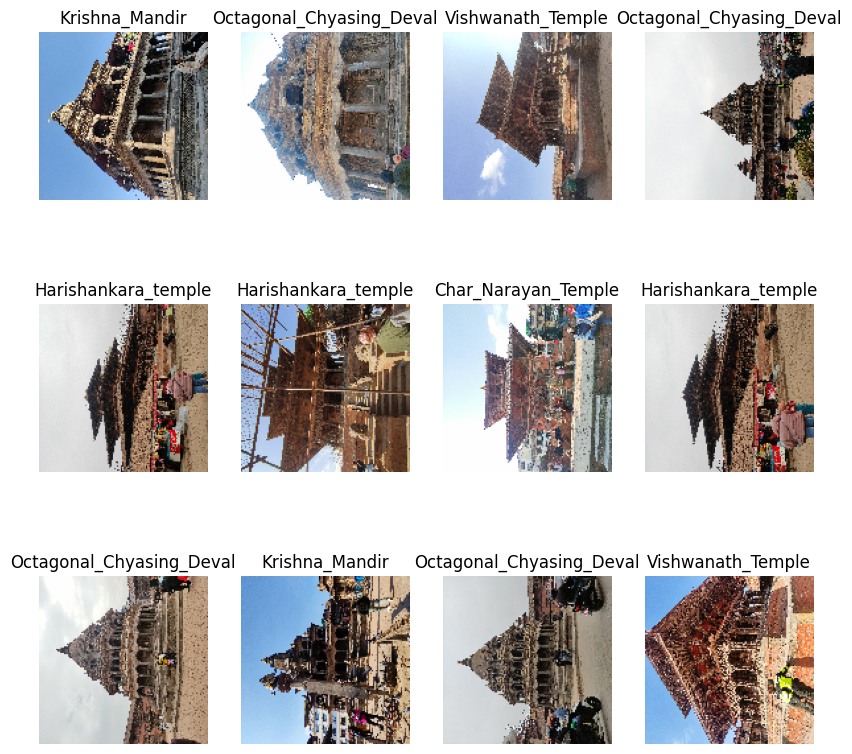

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

58

In [ ]:
train_size = 0.8
len(dataset)*train_size

46.400000000000006

In [ ]:
train_ds = dataset.take(15)
len(train_ds)

15

In [ ]:
test_ds = dataset.skip(15)
len(test_ds)

43

In [ ]:
val_size=0.1
len(dataset)*val_size

5.800000000000001

In [ ]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [ ]:
test_ds = test_ds.skip(1)
len(test_ds)

42

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

46

In [ ]:
len(val_ds)

5

In [ ]:
len(test_ds)

7

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

#### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
#     layers.experimental.preprocessing.RandomZoom(0.2),
#     layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    ])


#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

##Now take pre-trained model and retrain it using monuments images

In [ ]:
feature_extractor_model ="https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape= (IMAGE_SIZE, IMAGE_SIZE, CHANNELS), trainable=False)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    layers.Input(shape=(None, None, 3)),
    resize_and_rescale,
    pretrained_model_without_top_layer,
    layers.Dense(120, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(80, activation='relu'),
    layers.Dropout(0.3),
#     layers.Dense(60, activation='relu'),

#     layers.Dense(30, activation='relu'),

    layers.Dense(18, activation='relu'),

    layers.Dense(n_classes, activation='softmax'),
])


In [ ]:
#model.build()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 18)                2178      
                                                                 
 dense_2 (Dense)             (None, 9)                 171       
                                                                 
Total params: 1815078 (6.92 MB)
Trainable params: 1225

In [ ]:
# # Get and print the weights of each layer
# for layer in model.layers:
#     if layer.get_weights():
#         print(f"\nLayer: {layer.name}")
#         weights = layer.get_weights()
#         print(f"Weights:\n{weights}")

#         # Check if biases exist
#         if len(weights) > 1:
#             biases = weights[1]
#             print(f"Biases:\n{biases}")

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
# class CustomCallback(Callback):
#     def __init__(self, target_accuracy=0.9):
#         super(CustomCallback, self).__init__()
#         self.target_accuracy = target_accuracy

#     def on_epoch_end(self, epoch, logs=None):
#         if logs.get('val_accuracy') >= self.target_accuracy and logs.get('accuracy') >= self.target_accuracy :
#             print(f"\nReached target accuracy of {self.target_accuracy}. Stopping training.")
#             self.model.stop_training = True

In [ ]:
# Instantiate the custom callback
# custom_callback = CustomCallback(target_accuracy=0.9)


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)


In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    # callbacks=[custom_callback]
#     callbacks=[early_stopping]
)

Epoch 1/50
46/46 [==============================] - 670s 3s/step - loss: 1.8748 - accuracy: 0.2859 - val_loss: 1.4979 - val_accuracy: 0.4250
Epoch 2/50
46/46 [==============================] - 3s 63ms/step - loss: 1.1557 - accuracy: 0.6029 - val_loss: 0.8922 - val_accuracy: 0.7250
Epoch 3/50
46/46 [==============================] - 3s 74ms/step - loss: 0.8680 - accuracy: 0.6858 - val_loss: 0.6684 - val_accuracy: 0.8375
Epoch 4/50
46/46 [==============================] - 3s 73ms/step - loss: 0.6470 - accuracy: 0.7790 - val_loss: 0.5914 - val_accuracy: 0.8188
Epoch 5/50
46/46 [==============================] - 3s 63ms/step - loss: 0.6073 - accuracy: 0.7790 - val_loss: 0.4186 - val_accuracy: 0.8562
Epoch 6/50
46/46 [==============================] - 3s 63ms/step - loss: 0.5308 - accuracy: 0.8177 - val_loss: 0.3731 - val_accuracy: 0.8875
Epoch 7/50
46/46 [==============================] - 4s 83ms/step - loss: 0.4691 - accuracy: 0.8453 - val_loss: 0.3646 - val_accuracy: 0.9062
Epoch 8/50
46

In [ ]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 148s 13ms/step - loss: 0.3065 - accuracy: 0.8973


In [ ]:
scores

Scores is just a list containing loss and accuracy value

In [ ]:
# Get and print the weights of each layer
for layer in model.layers:
    if layer.get_weights():
        print(f"\nLayer: {layer.name}")
        weights = layer.get_weights()
        print(f"Weights:\n{weights}")

        # Check if biases exist
        if len(weights) > 1:
            biases = weights[1]
            print(f"Biases:\n{biases}")

Streaming output truncated to the last 5000 lines.
         [-0.7899287 ],
         [-1.9005014 ],
         [-1.1195793 ],
         [-1.1517864 ],
         [ 1.2797483 ],
         [ 1.3483577 ],
         [-1.4267706 ],
         [ 1.6705636 ],
         [-1.4786239 ],
         [ 1.3693589 ],
         [-0.97440505],
         [ 0.04667285],
         [ 1.1505167 ],
         [-0.9296282 ],
         [ 1.7029434 ],
         [ 1.24266   ],
         [ 1.0699464 ],
         [ 1.0648723 ],
         [ 0.6216502 ],
         [ 1.1008348 ],
         [-1.5041224 ]],

        [[-1.6166924 ],
         [ 1.6914799 ],
         [ 1.7305726 ],
         [ 1.3902649 ],
         [-1.8331401 ],
         [ 1.9379444 ],
         [-0.78103864],
         [ 1.6989526 ],
         [ 1.7307041 ],
         [ 1.7205814 ],
         [-0.90651727],
         [-0.8976646 ],
         [-1.5464975 ],
         [ 2.6383908 ],
         [-1.2425358 ],
         [ 1.8214017 ],
         [ 1.715032  ],
         [-0.6495895 ],
         [-

### Plotting the Accuracy and Loss Curves

In [ ]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 46}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.8747681379318237,
 1.1556975841522217,
 0.8679907917976379,
 0.647042989730835,
 0.6073154211044312]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

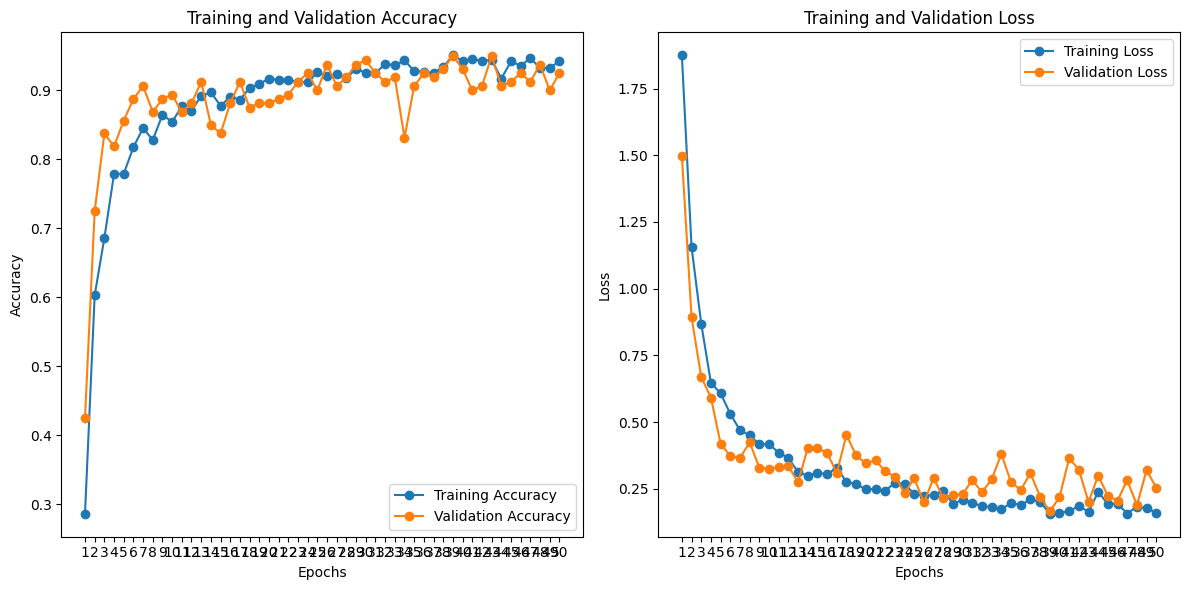

In [ ]:
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), acc, label='Training Accuracy', marker='o')
plt.plot(range(1, EPOCHS + 1), val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, EPOCHS + 1))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, EPOCHS + 1), val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, EPOCHS + 1))

plt.tight_layout()
plt.show()


### Run prediction on a sample image

[[[223 228 224]
  [223 227 226]
  [225 227 224]
  ...
  [ 99  65  36]
  [106  75  44]
  [118  94  58]]

 [[223 227 226]
  [224 227 226]
  [222 226 225]
  ...
  [104  69  37]
  [101  71  45]
  [108  87  54]]

 [[221 227 225]
  [224 227 226]
  [222 227 226]
  ...
  [ 99  68  39]
  [100  70  42]
  [114  91  58]]

 ...

 [[223 227 228]
  [223 224 226]
  [222 225 224]
  ...
  [140 127 101]
  [108  90  65]
  [117  99  75]]

 [[223 224 226]
  [224 225 227]
  [224 225 227]
  ...
  [136 120  94]
  [ 96  78  56]
  [ 93  70  53]]

 [[223 224 226]
  [223 224 226]
  [224 226 227]
  ...
  [144 128 100]
  [ 97  75  56]
  [ 84  63  43]]]
first image to predict
actual label: Harishankara_temple
1/1 [==============================] - 0s 496ms/step
predicted label: Harishankara_temple
4
tf.Tensor(
[[[113.41016   160.41016   212.41016  ]
  [115.75      162.75      216.75     ]
  [117.76172   164.76172   218.76172  ]
  ...
  [ 14.09375    15.082031   19.894531 ]
  [ 10.488281   10.488281   12.488281 ]
  [ 

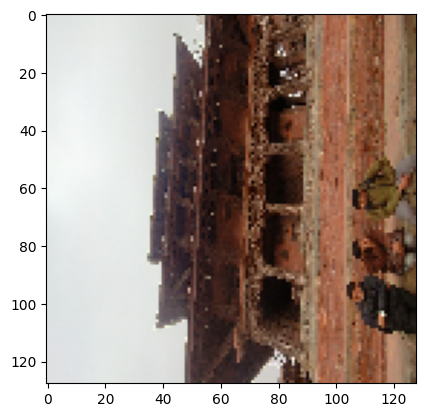

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print(first_image)

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    print(np.argmax(batch_prediction[0]))
    print(image_batch[0])

In [ ]:
# from tensorflow.keras.preprocessing import image
# import numpy as np

# # Load and preprocess the input image
# img_path = r"C:\Users\pokha\monument_detection project\training\images\bouddhanath\istockphoto-1153332337-612x612.jpg"  # Replace with the actual path to your image
# img = image.load_img(img_path, target_size=(128,128))  # Adjust target_size based on your model's input size
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0  # Normalize pixel values if needed


In [ ]:
# predictions1 = model.predict(img_array)

In [ ]:
# predicted_class = np.argmax(predictions1)


In [ ]:
# predicted_class


### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 19ms/step


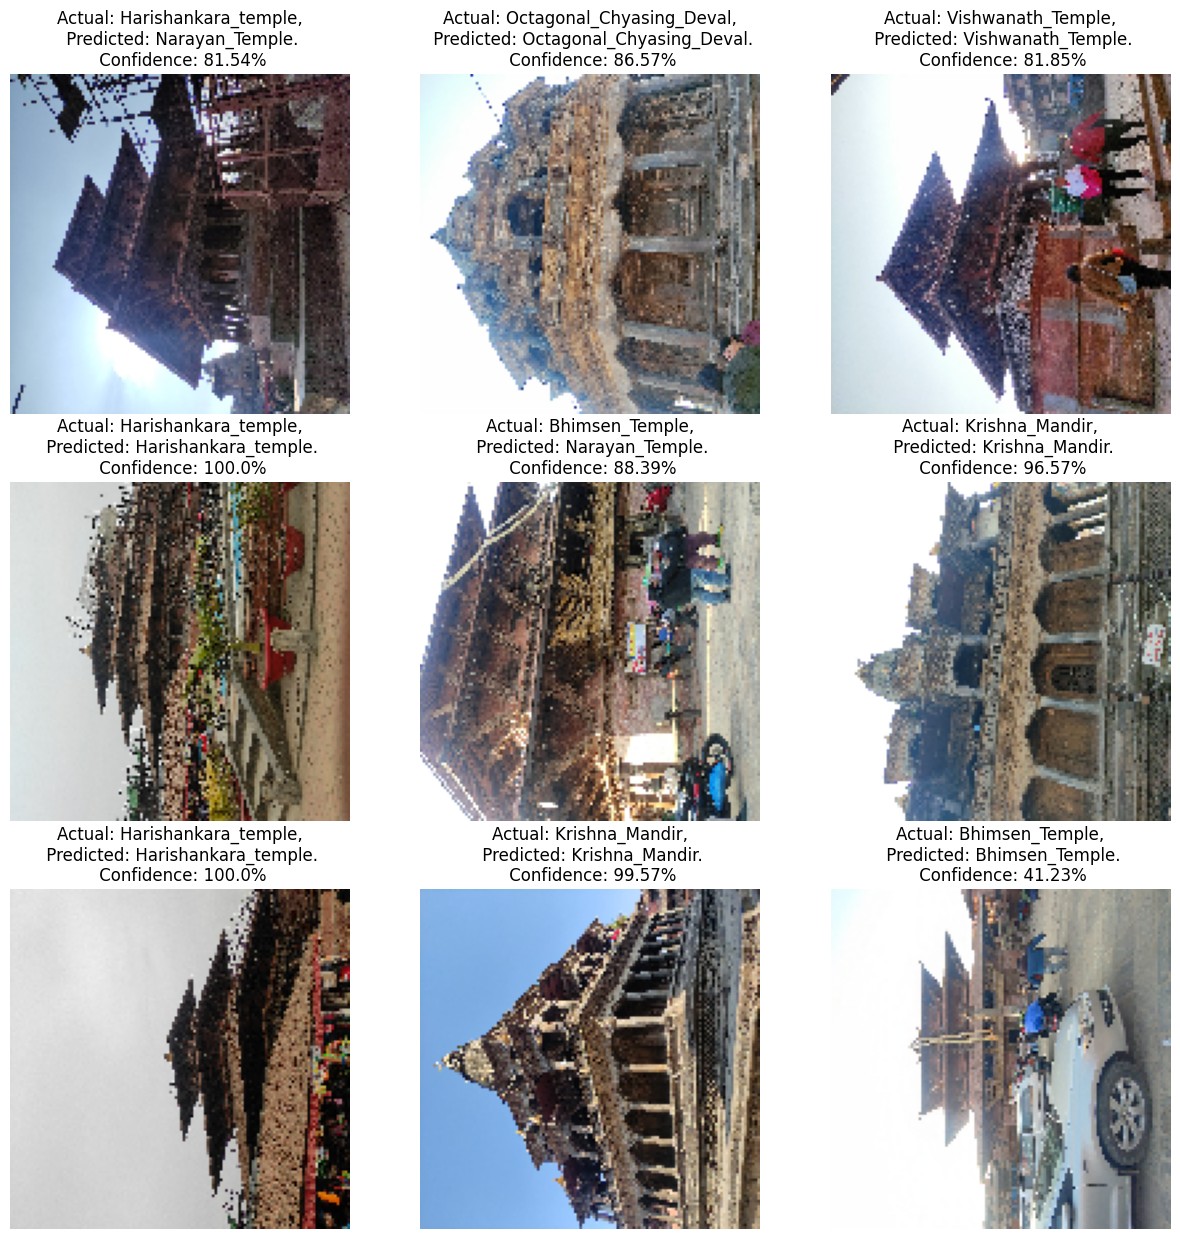

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 32ms/step
Confusion matrix, without normalization
[[29  0  0  0  1  0  5  1  0]
 [ 0 18  0  0  1  1  1  1  0]
 [ 0  0 19  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0]
 [ 0  0  0  0 26  0  4  0  0]
 [ 0  0  0  1  2 22  2  0  0]
 [ 0  0  0  0  1  0 36  0  0]
 [ 0  0  0  0  0  0  0 19  0]
 [ 0  1  0  0  0  0  1  0 16]]
Normalized confusion matrix
[[0.80555556 0.         0.         0.         0.02777778 0.
  0.13888889 0.02777778 0.        ]
 [0.         0.81818182 0.         0.         0.04545455 0.04545455
  0.04545455 0.04545455 0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.86666667 0.
  0.13333333 0.         0.        ]
 [0.         0.         0.         0.03703704 0.07407407 0.81481481
  0.07407407 0.         0.        ]
 [0.         0.  

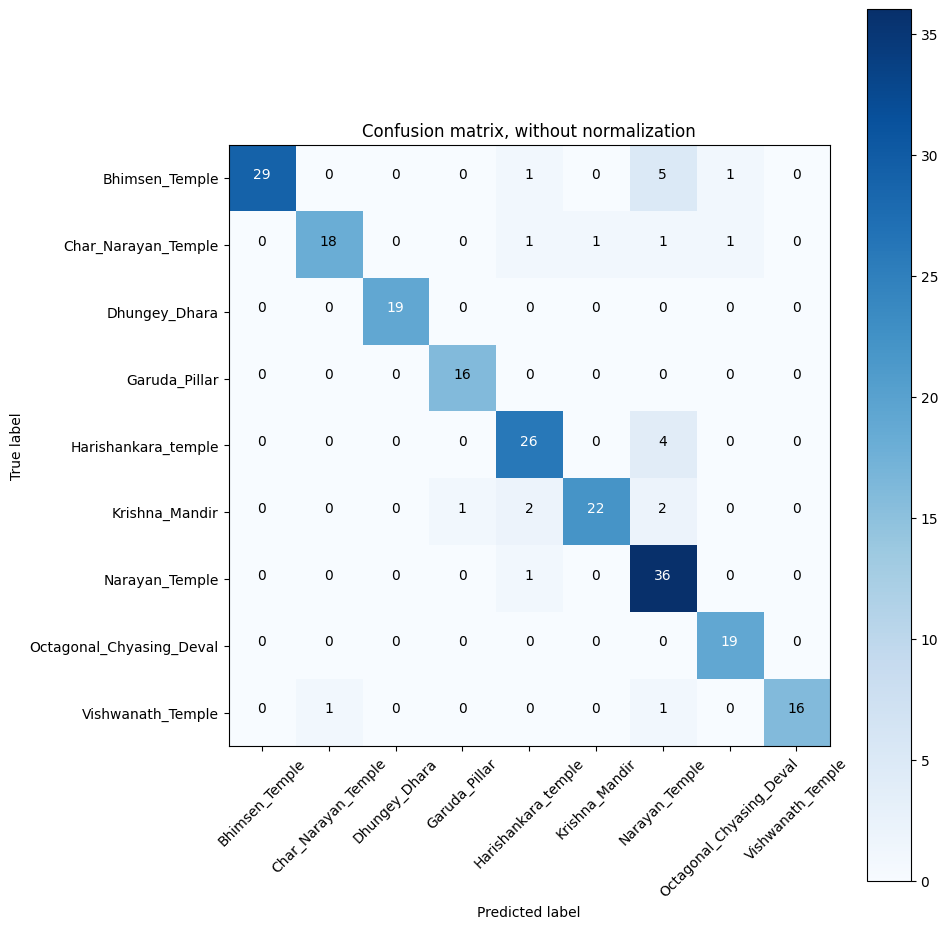

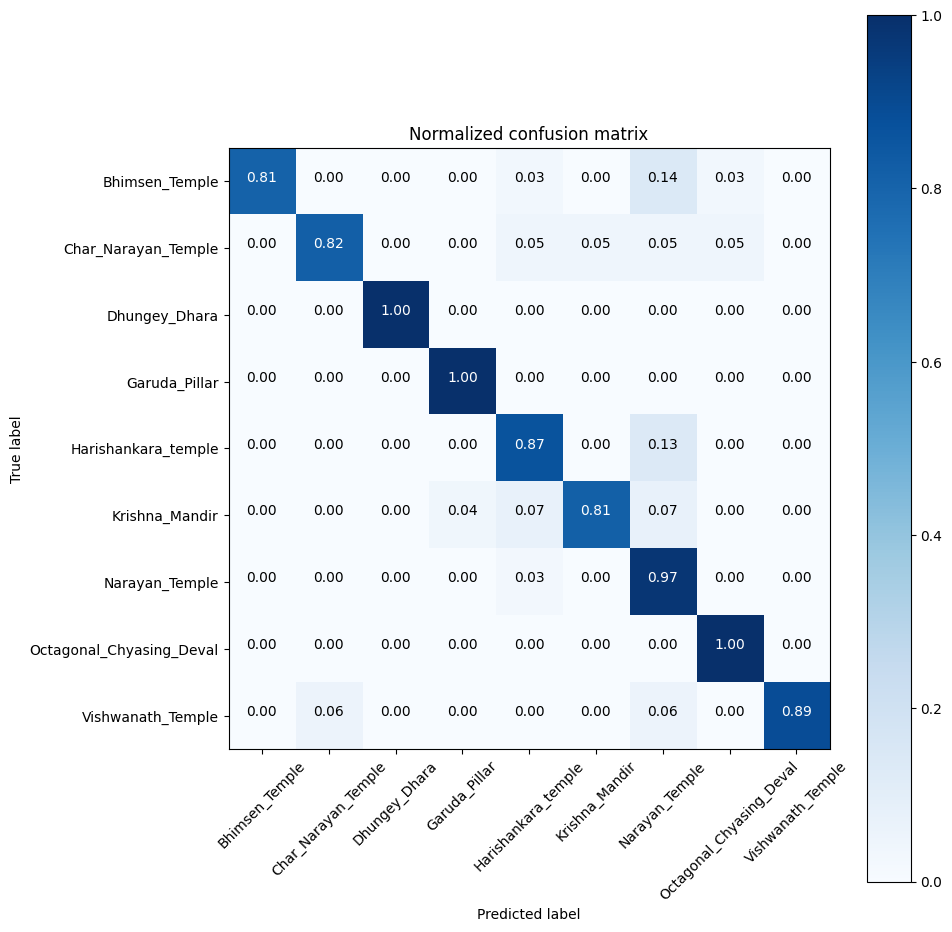

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Collect true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    for i in range(len(labels)):
        true_labels.append(labels[i].numpy())
        predicted_class, _ = predict(model, images[i].numpy())
        predicted_labels.append(class_names.index(predicted_class))

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


### Saving the Model
We append the model to the list of models as a new version

In [ ]:
# Specify the path in your Google Drive where you want to save the model
import os
drive_path = '/content/drive/My Drive/saved_models'

# Create the directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Save the model to Google Drive
# model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
# model.save(drive_path + f'/model_{model_version}')
model.save(drive_path + f'/model_3')

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")